In [3]:
# Imports
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
import json
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import kagglehub
import spacy

np.random.seed(42)
torch.manual_seed(42)

In [4]:
# Device setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [5]:
# Load COCO dataset
path = kagglehub.dataset_download("nagasai524/mini-coco2014-dataset-for-image-captioning")

with open(os.path.join(path, "captions.json"), "r") as f:
    data = json.load(f)
    annotations = data["annotations"] if isinstance(data, dict) else data

captions = {}
for item in annotations:
    img_id = item["image_id"]
    if img_id not in captions:
        captions[img_id] = []
    captions[img_id].append(item["caption"])

for root, dirs, files in os.walk(path):
    if any(f.endswith(".jpg") for f in files):
        img_folder = root
        break

img_ids = list(captions.keys())
print(f"Ready: {len(captions)} images loaded")

Ready: 18783 images loaded


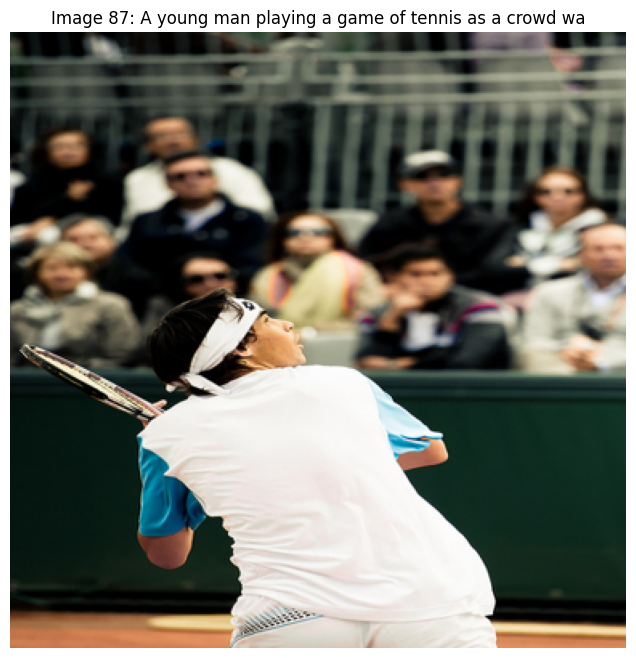


Image 87 captions:
  - A young man playing a game of tennis as a crowd watches.
  - A tennis player holding a racket is looking up.
  - A tennis player in the middle of a play with spectators in the background.
  - Tennis player about to hit a tennis ball
  - Tennis player holding a racket looking up on a tennis court. 


In [6]:
# Image loading function
def get_image(idx):
    """Load and resize image to 384x384"""
    img_id = img_ids[idx]
    img_path = os.path.join(img_folder, f"COCO_train2014_{img_id:012d}.jpg")
    if not os.path.exists(img_path):
        img_path = os.path.join(img_folder, f"{img_id}.jpg")
    return Image.open(img_path).convert("RGB").resize((384, 384)), captions[img_id]

# Show selected image
selected = [87]
fig, axes = plt.subplots(1, len(selected), figsize=(8, 8))
if len(selected) == 1:
    axes = [axes]

for idx, ax in zip(selected, axes):
    img, caps = get_image(idx)
    ax.imshow(img)
    ax.set_title(f"Image {idx}: {caps[0][:50]}")
    ax.axis("off")
plt.show()

for idx in selected:
    img, caps = get_image(idx)
    print(f"\nImage {idx} captions:")
    for cap in caps:
        print(f"  - {cap}")

In [7]:
# Normalize images
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.48145466, 0.4578275, 0.40821073], 
                        [0.26862954, 0.26130258, 0.27577711])
])

def to_tensor(idx):
    img, _ = get_image(idx)
    return normalize(img).unsqueeze(0).to(device)

test = to_tensor(0)
print(f"Tensor ready for BLIP: {test.shape}")

Tensor ready for BLIP: torch.Size([1, 3, 384, 384])


In [8]:
# Load BLIP model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to(device)
model.eval()
print("BLIP model loaded")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


BLIP model loaded


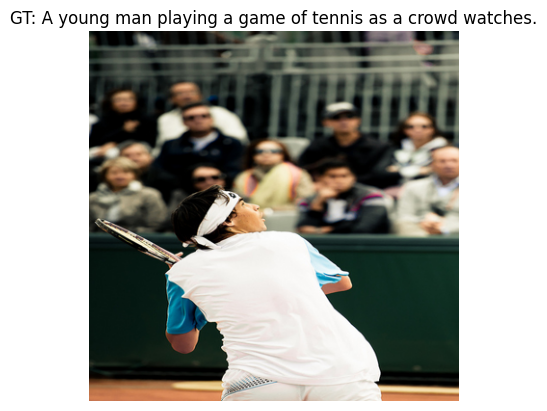

Image index: 87
Ground truth: A young man playing a game of tennis as a crowd watches.
BLIP caption: there is a man that is playing tennis on a court


In [9]:
# Generate caption baseline
def generate_blip_caption(idx, show_image=True):
    """Run BLIP on one COCO image and print GT and predicted captions"""
    img, gt_caps = get_image(idx)

    if show_image:
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"GT: {gt_caps[0][:60]}")
        plt.show()

    inputs = processor(img, return_tensors="pt").to(device)

    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=30)

    pred_caption = processor.decode(output_ids[0], skip_special_tokens=True)

    print(f"Image index: {idx}")
    print(f"Ground truth: {gt_caps[0]}")
    print(f"BLIP caption: {pred_caption}")

    return img, gt_caps, pred_caption

# Test
for i in [87]:
    generate_blip_caption(i, show_image=True)

In [10]:
# Extract attention
def extract_blip_attention(idx):
    """Extract vision attention from BLIP model"""
    img, gt_caps = get_image(idx)
    inputs = processor(img, return_tensors="pt").to(device)
    
    vision_attentions = []
    
    def hook_fn(module, input, output):
        if len(output) > 1 and output[1] is not None:
            vision_attentions.append(output[1].detach())
    
    hooks = []
    for layer in model.vision_model.encoder.layers:
        hook = layer.self_attn.register_forward_hook(hook_fn)
        hooks.append(hook)
    
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=30)
        pred_caption = processor.decode(outputs[0], skip_special_tokens=True)
    
    for hook in hooks:
        hook.remove()
    
    print(f"Caption: {pred_caption}")
    print(f"Captured {len(vision_attentions)} layers of attention")
    
    return img, gt_caps, pred_caption, vision_attentions

In [11]:
# Aggregation methods
try:
    nlp = spacy.load("en_core_web_sm")
except:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Baseline 1: Sentence-based (Paper's main method)
def aggregate_sentence_based(vision_attentions, k_percent=0.5):
    """Aggregate attention across all layers"""
    all_attention = []
    for layer_attn in vision_attentions:
        attn = layer_attn.mean(dim=1)
        cls_to_patches = attn[0, 0, 1:]
        all_attention.append(cls_to_patches)
    
    aggregated = torch.stack(all_attention).mean(dim=0)
    aggregated_2d = aggregated.reshape(24, 24)
    
    k = int(576 * k_percent)
    threshold = torch.topk(aggregated.flatten(), k).values.min()
    mask = (aggregated_2d >= threshold).float()
    
    return aggregated_2d.cpu().numpy(), mask.cpu().numpy()


# Baseline 2: Word-based (Paper's baseline)
def aggregate_word_based(vision_attentions, k_percent=0.5):
    """Select top-k patches per layer, then union"""
    k_per_layer = int(576 * k_percent / len(vision_attentions))
    selected_patches = torch.zeros(576)
    
    for layer_attn in vision_attentions:
        attn = layer_attn.mean(dim=1)
        cls_to_patches = attn[0, 0, 1:]
        top_k_indices = torch.topk(cls_to_patches, k_per_layer).indices
        selected_patches[top_k_indices] = 1
    
    aggregated_2d = selected_patches.reshape(24, 24)
    
    all_attention = []
    for layer_attn in vision_attentions:
        attn = layer_attn.mean(dim=1)
        all_attention.append(attn[0, 0, 1:])
    aggregated_vis = torch.stack(all_attention).mean(dim=0).reshape(24, 24)
    
    return aggregated_vis.cpu().numpy(), aggregated_2d.cpu().numpy()


# Novel Method 1: POS-weighted
def aggregate_pos_weighted(vision_attentions, caption, k_percent=0.5):
    """Weight attention by POS tags (nouns/verbs weighted higher)"""
    doc = nlp(caption)
    
    weights = []
    for token in doc:
        if token.pos_ in ["NOUN", "PROPN"]:
            weights.append(2.0)
        elif token.pos_ == "VERB":
            weights.append(1.5)
        else:
            weights.append(1.0)
    
    all_attention = []
    for i, layer_attn in enumerate(vision_attentions):
        attn = layer_attn.mean(dim=1)
        cls_to_patches = attn[0, 0, 1:]
        weight = weights[i % len(weights)]
        all_attention.append(cls_to_patches * weight)
    
    aggregated = torch.stack(all_attention).mean(dim=0)
    aggregated_2d = aggregated.reshape(24, 24)
    
    k = int(576 * k_percent)
    threshold = torch.topk(aggregated.flatten(), k).values.min()
    mask = (aggregated_2d >= threshold).float()
    
    return aggregated_2d.cpu().numpy(), mask.cpu().numpy()


# Novel Method 2: Temporal-decay
def aggregate_temporal_decay(vision_attentions, k_percent=0.5, decay=0.95):
    """Later layers weighted lower (exponential decay)"""
    all_attention = []
    
    for i, layer_attn in enumerate(vision_attentions):
        attn = layer_attn.mean(dim=1)
        cls_to_patches = attn[0, 0, 1:]
        weight = decay ** i
        all_attention.append(cls_to_patches * weight)
    
    aggregated = torch.stack(all_attention).mean(dim=0)
    aggregated_2d = aggregated.reshape(24, 24)
    
    k = int(576 * k_percent)
    threshold = torch.topk(aggregated.flatten(), k).values.min()
    mask = (aggregated_2d >= threshold).float()
    
    return aggregated_2d.cpu().numpy(), mask.cpu().numpy()


# Novel Method 3: Variance-based
def aggregate_variance_based(vision_attentions, k_percent=0.5):
    """Select patches with high variance across layers"""
    all_attention = []
    for layer_attn in vision_attentions:
        attn = layer_attn.mean(dim=1)
        cls_to_patches = attn[0, 0, 1:]
        all_attention.append(cls_to_patches)
    
    all_attention = torch.stack(all_attention)
    variance = all_attention.var(dim=0)
    variance_2d = variance.reshape(24, 24)
    
    k = int(576 * k_percent)
    threshold = torch.topk(variance.flatten(), k).values.min()
    mask = (variance_2d >= threshold).float()
    
    return variance_2d.cpu().numpy(), mask.cpu().numpy()


# Novel Method 4: Entropy-based
def aggregate_entropy_based(vision_attentions, k_percent=0.5):
    """Select patches with high entropy (uncertainty)"""
    all_attention = []
    for layer_attn in vision_attentions:
        attn = layer_attn.mean(dim=1)
        cls_to_patches = attn[0, 0, 1:]
        all_attention.append(cls_to_patches)
    
    all_attention = torch.stack(all_attention)
    all_attention = torch.softmax(all_attention, dim=1)
    
    epsilon = 1e-10
    entropy = -(all_attention * torch.log(all_attention + epsilon)).sum(dim=0)
    entropy_2d = entropy.reshape(24, 24)
    
    k = int(576 * k_percent)
    threshold = torch.topk(entropy.flatten(), k).values.min()
    mask = (entropy_2d >= threshold).float()
    
    return entropy_2d.cpu().numpy(), mask.cpu().numpy()

print("All 6 aggregation methods loaded!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.9 MB/s  0:00:03m0:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
All 6 aggregation methods loaded!


In [12]:
# Visualization function
def visualize_attention_overlay(img, pred_caption, agg_attn, mask, method_name="Sentence-based"):
    """Visualize attention with overlay on original image"""
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(img)
    axes[0].set_title(f"Original\n{pred_caption[:40]}")
    axes[0].axis("off")
    
    img_array = np.array(img.resize((384, 384)))
    attn_resized = np.array(Image.fromarray((agg_attn * 255).astype(np.uint8)).resize((384, 384)))
    attn_resized = attn_resized / 255.0
    
    axes[1].imshow(img_array)
    axes[1].imshow(attn_resized, cmap="hot", alpha=0.5)
    axes[1].set_title(f"{method_name}\nHeatmap Overlay")
    axes[1].axis("off")
    
    axes[2].imshow(agg_attn, cmap="hot", interpolation="bilinear")
    axes[2].set_title("Attention Heatmap\n(Smoothed)")
    axes[2].axis("off")
    
    mask_resized = np.array(Image.fromarray((mask * 255).astype(np.uint8)).resize((384, 384), Image.NEAREST))
    mask_resized = mask_resized / 255.0
    
    axes[3].imshow(img_array)
    axes[3].imshow(mask_resized, cmap="Reds", alpha=0.4)
    axes[3].set_title(f"Top 50% Patches\nSelected for Attack")
    axes[3].axis("off")
    
    plt.tight_layout()
    plt.show()

Caption: there is a man that is playing tennis on a court
Captured 24 layers of attention

=== Sentence-based ===


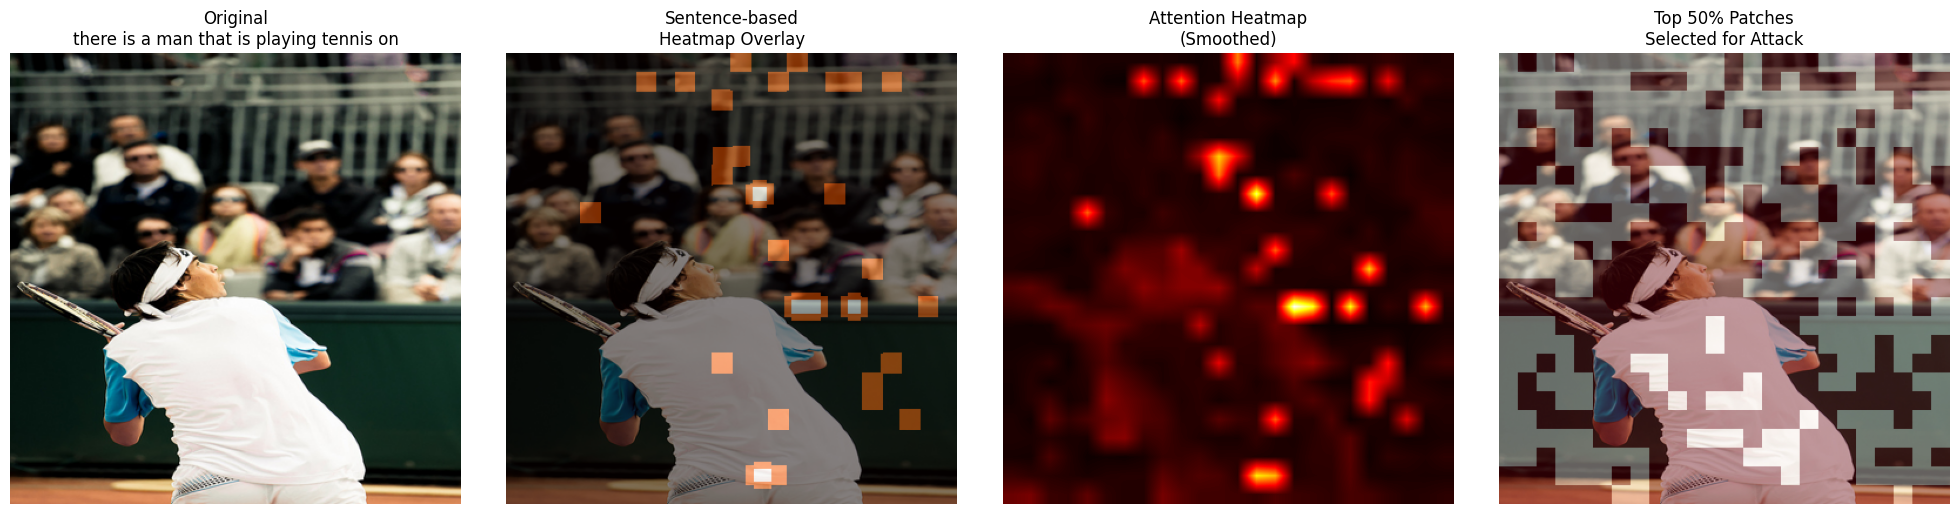


=== Word-based ===


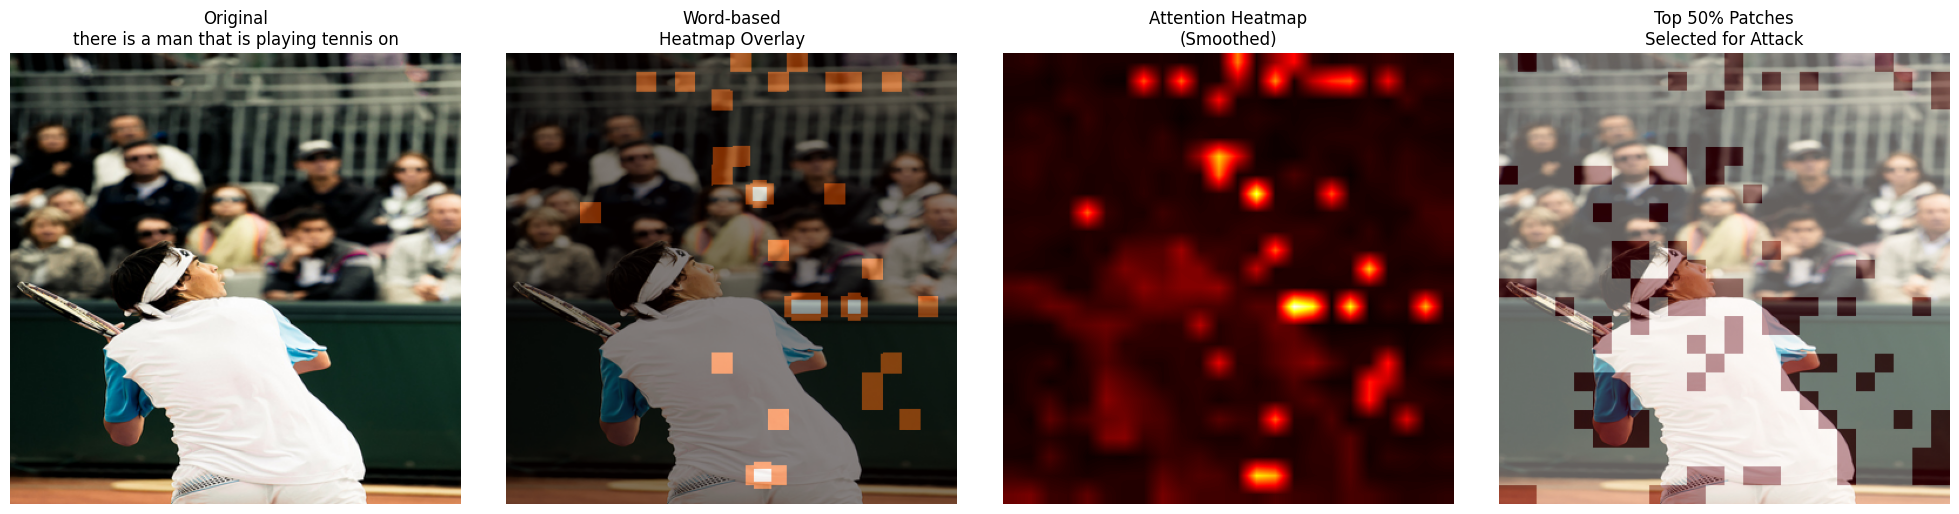


=== POS-weighted ===


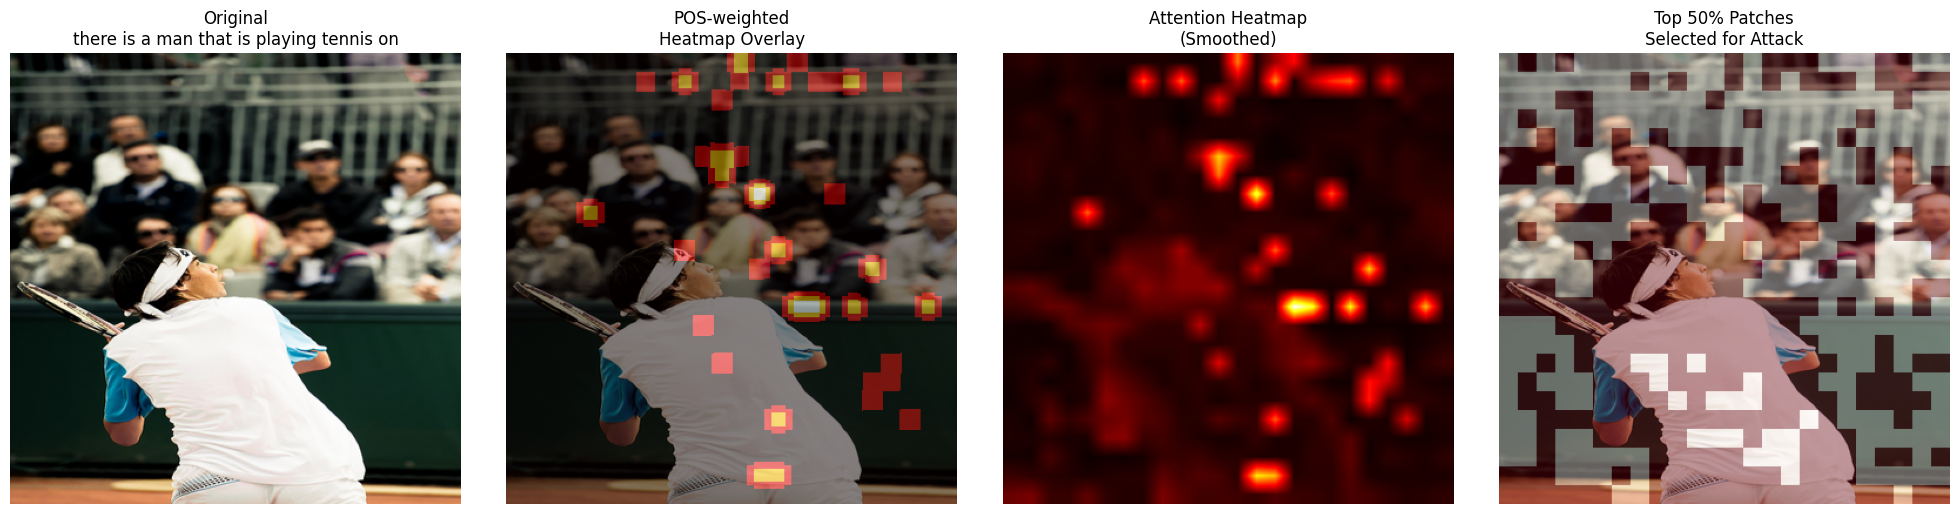


=== Temporal-decay ===


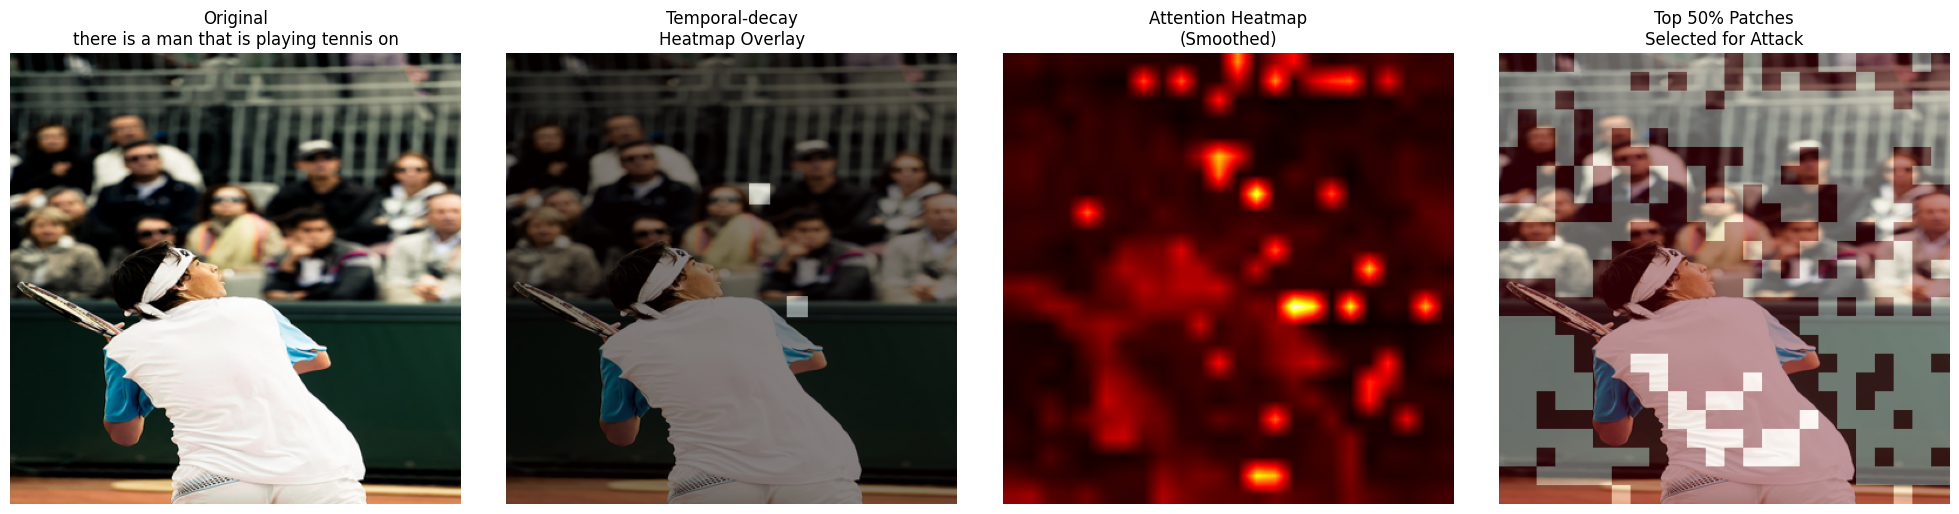


=== Variance-based ===


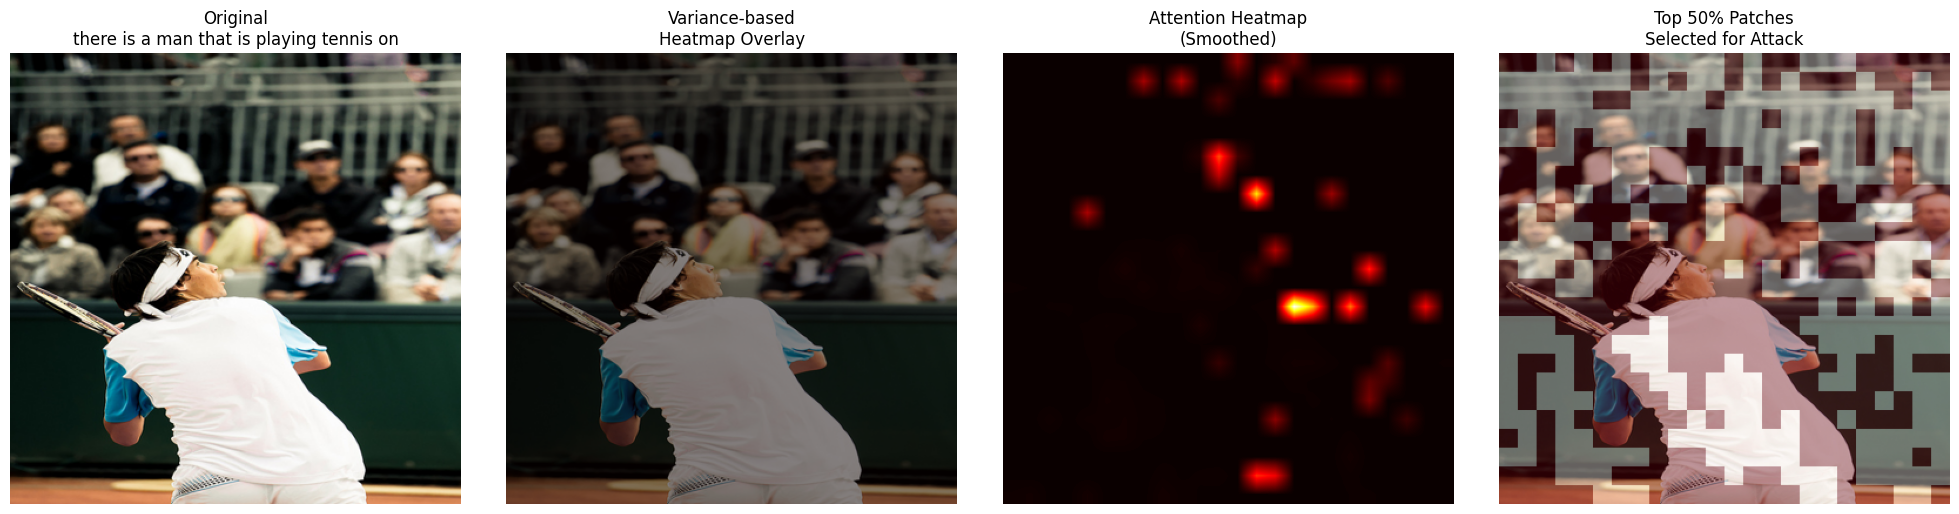


=== Entropy-based ===


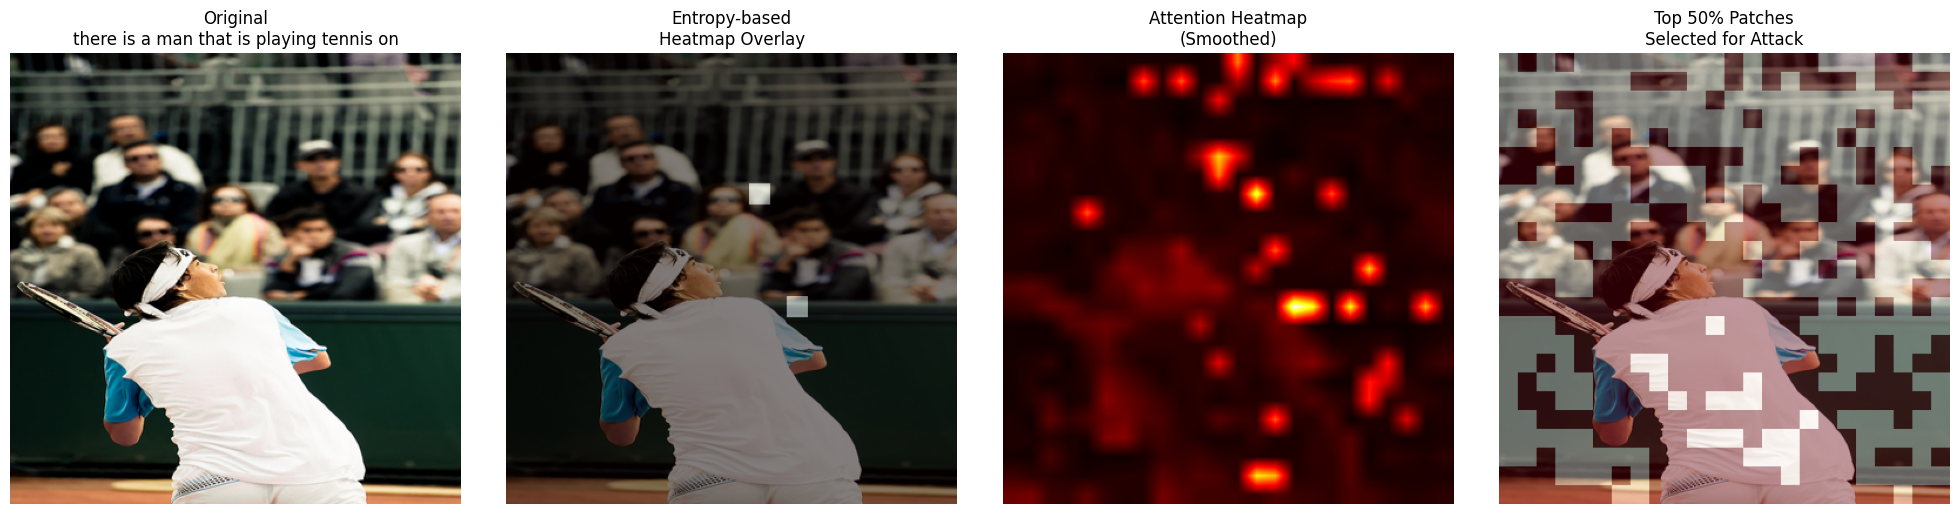

In [13]:
# Compare all 6 methods on selected image
idx = 87
img, gt_caps, pred_caption, vision_attn = extract_blip_attention(idx)

methods = {
    "Sentence-based": lambda: aggregate_sentence_based(vision_attn),
    "Word-based": lambda: aggregate_word_based(vision_attn),
    "POS-weighted": lambda: aggregate_pos_weighted(vision_attn, pred_caption),
    "Temporal-decay": lambda: aggregate_temporal_decay(vision_attn),
    "Variance-based": lambda: aggregate_variance_based(vision_attn),
    "Entropy-based": lambda: aggregate_entropy_based(vision_attn)
}

for name, method in methods.items():
    print(f"\n=== {name} ===")
    agg, mask = method()
    visualize_attention_overlay(img, pred_caption, agg, mask, name)